In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from lib.lib import gauss_newton, LevenbergMarquardt, DifferentiableFunction, gradient_descent
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## Example functions

$$p \in \R^N = \R^3, \forall_{0 \leq i < M} \, x^{[i]} \in \R^K = \R^2, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^N \to \R, \qquad f(x, p) = p_0 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [x_0, x_1, 1]^T$$

$$ R : \R^N \to \R^M, \qquad R(p) = \left[(f(x^{[i]}, p) - y^{[i]})^2\right]_{0 \leq i < M} $$

$$ D_pR(p) = \left[2(f(x^{[i]}, p) - y^{[i]})\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < M, 0 \leq j < N}$$

In [118]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
ys = np.array([1, 2, 3, 4])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0] * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([x[0], x[1], 1])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return (fs - ys)**2


def residue_jacobian(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])
    dfs = np.array([df(x, p) for x in xs])

    return np.array([2 * (fs[i] - ys[i]) * dfs[i] for i in range(len(xs))])

In [119]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(f, df, ys, xs, p)

R = DifferentiableFunction(R_value, R_derivative, 3, 4)

In [120]:
def F_value(p: np.ndarray) -> np.ndarray:
    assert p.shape == (1,)
    return (p**2).reshape(1,)

def F_derivative(p: np.ndarray) -> np.ndarray:
    assert p.shape == (1,)
    return (2 * p).reshape(1, 1)

F = DifferentiableFunction(F_value, F_derivative, 1, 1)

# TEST
# TODO remove later

In [121]:
p0 = np.array([21.37])
max_iter = 10000

In [122]:
p, err = gradient_descent(F, p0, 0.001, 1000)
p

array([0.48248101])

In [123]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter)
p

array([5.63698789e-110])

In [124]:
p, err = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultOptimizer(lambda0=0.01, lambda_change=1.1, eps=1e-100)
).optimize(p0=p0, max_iter=max_iter)
p

array([5.6034308e-53])

## Hyperparameters

In [125]:
# p0 = np.random.randn(3)
p0 = np.array([1.5, 0.6, -3.14])
max_iter = 1000

## Gradient descent method

In [126]:
p, err = gradient_descent(R, p0, 0.0001, max_iter)
print(f"{p=}, {err=}")

p=array([0.44367209, 0.20333256, 0.75966047]), err=0.4284527279857192


In [127]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1.60999768, 2.25700233, 2.90400698, 3.55101163])

## Gauss-Newton method

In [128]:
p, err = gauss_newton(R, p0, max_iter, silent=True)
print(f"{p=}, {err=}")

p=array([1, 1, 1]), err=47.51841748206689


In [129]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([ 4,  6,  8, 10])

## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [130]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)
p, err = optimizer.optimize(p0, max_iter, silent=True)
print(f"{p=}, {err=}")

p=array([9.99391609e-01, 2.22020994e-04, 8.30411756e-04]), err=5.125006403575419e-07


In [131]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1.00066606, 2.00027969, 2.99989332, 3.99950695])

### Test parameters

In [132]:
lambda_params = [10**i for i in range(-10, 2)]
errors_levenberg_marquardt_constant_param = []
p0s = [np.random.randn(3) for _ in range(10)]

for lambda_param in lambda_params:
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, silent=True)
        errs.append(err)
    
    errors_levenberg_marquardt_constant_param.append(errs)

errors_gauss_newton = []
for p0 in p0s:
    p, err = gauss_newton(R=R, p0=p0, max_iter=max_iter, silent=True)
    errors_gauss_newton.append(err)

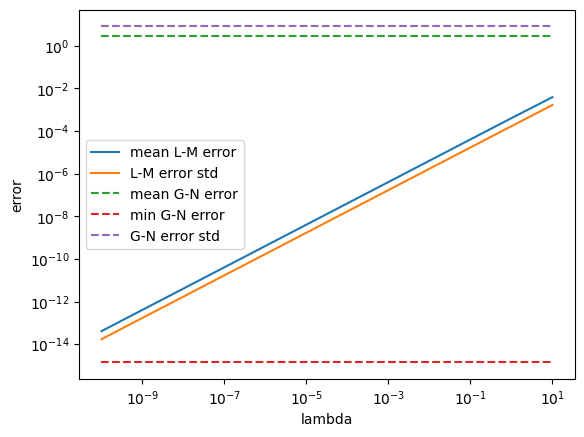

In [133]:
errors_mean = np.mean(errors_levenberg_marquardt_constant_param, axis=1)
errors_std = np.std(errors_levenberg_marquardt_constant_param, axis=1)

errors_gn_mean = np.mean(errors_gauss_newton)
errors_gn_std = np.std(errors_gauss_newton)

plt.loglog(lambda_params, errors_mean, label="mean L-M error")
plt.loglog(lambda_params, errors_std, label="L-M error std")

plt.loglog(lambda_params, [errors_gn_mean] * len(lambda_params), label="mean G-N error", linestyle="--")
plt.loglog(lambda_params, [np.min(errors_gauss_newton)] * len(lambda_params), label="min G-N error", linestyle="--")
plt.loglog(lambda_params, [errors_gn_std] * len(lambda_params), label="G-N error std", linestyle="--")

plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

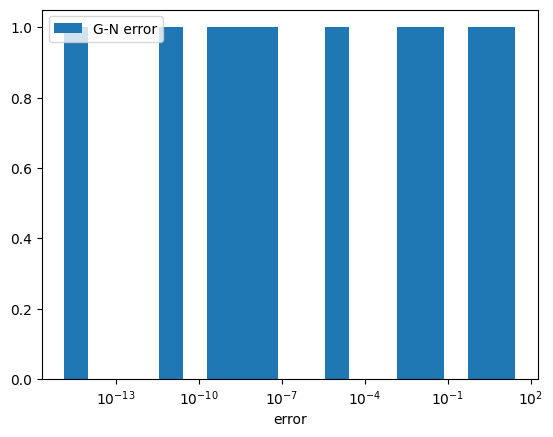

In [134]:
logbins = np.logspace(np.log10(np.min(errors_gauss_newton)), np.log10(np.max(errors_gauss_newton)), 20)
plt.hist(errors_gauss_newton, bins=logbins, label="G-N error")
plt.xscale("log")
plt.xlabel("error")
plt.legend()
plt.show()

#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [135]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultOptimizer(
        lambda0=0.1, lambda_change=2
    ),
)
p, err = optimizer.optimize(p0, max_iter, silent=True)
print(f"{p=}, {err=}")

p=array([ 0.92262365,  0.07737635, -0.07737635]), err=5.0697363578716395e-20


In [136]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])